In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import numpy as np
import os
from math import floor
# Load the keras layers and models
import cv2
from tqdm import tqdm
from keras.preprocessing import image
from tensorflow.keras.layers import Dense,Flatten,Softmax,ReLU,Input,Conv2D,MaxPool2D,Dropout,Activation
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib 
from PIL import Image
import random
import matplotlib.pyplot as plt
print(device_lib.list_local_devices())
tf.keras.backend.set_floatx('float64')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9038214614241857937
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1201460612053522798
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17492545744655412061
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7470045594
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4106951898890592389
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


# Data Visualization

It is a dataset small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

Number of training samples  60000
Number of test samples  10000
Shape of sample (28, 28)
-----------------------------
Random sample images
-----------------------------


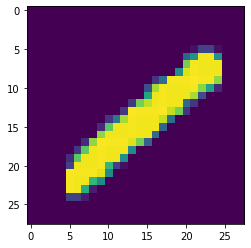

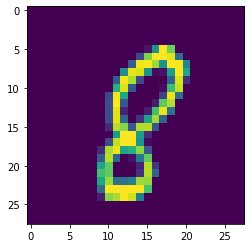

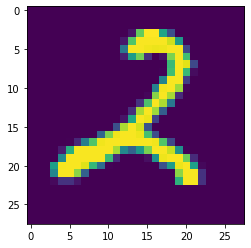

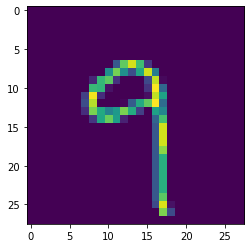

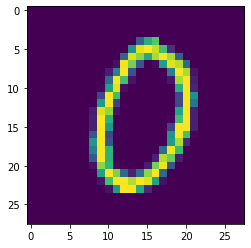

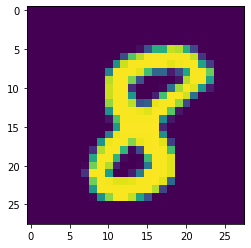

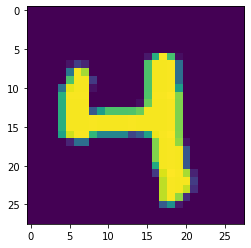

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Number of training samples ",len(x_train))
print("Number of test samples ",len(x_test))
print("Shape of sample",x_train[0].shape)
print("-----------------------------")
print("Random sample images")
print("-----------------------------")
res = [random.randrange(0, len(x_train), 1) for i in range(7)] 
for ind in res:
  fig = plt.figure()
  plt.imshow(x_train[ind])  

# Dataset Class 

This class is used to store data and for data augmentation. MNIST training images are padded to 30x30 pixels and random crop to 28x28 as mentioned in the paper.


Source:-https://github.com/hardmaru/supercell/blob/master/assets/MNIST_Static_HyperNetwork_Example.ipynb

In [0]:
# class to store mnist data and for data augmentation as suggested in paper.
class DataSet(object):
  def __init__(self, images, labels, augment=False):
    # Convert from [0, 255] -> [0.0, 1.0] -> [-1.0, 1.0]
    images = images.astype(np.float32)
    #images = images - 0.5
    #images = 2.0 * images
    self.image_size = 28
    self._num_examples = len(images)
    images = np.reshape(images, (self._num_examples, self.image_size, self.image_size, 1))
    perm = np.arange(self._num_examples)
    np.random.shuffle(perm)
    self._images = images[perm]
    self._labels = labels[perm]
    self._augment = augment
    self.pointer = 0
    self.upsize = 1 if self._augment else 0
    self.min_upsize = 2
    self.max_upsize = 2
    self.random_perm_mode=False
    self.num_classes = 10

  @property
  def images(self):
    return self._images
  @property
  def labels(self):
    return self._labels
  @property
  def num_examples(self):
    return self._num_examples

  def next_batch(self, batch_size=100, with_label = True, one_hot = False):
    if self.pointer >= self.num_examples-2*batch_size:
      self.pointer = 0
    else:
      self.pointer += batch_size
    result = []
    
    upsize_amount = np.random.randint(self.upsize*self.min_upsize, self.upsize*self.max_upsize+1)
    


    def upsize_row_once(img):
      old_size = img.shape[0]
      new_size = old_size+1
      new_img = np.zeros((new_size, img.shape[1], 1))
      rand_row = np.random.randint(1, old_size-1)
      new_img[0:rand_row,:] = img[0:rand_row,:]
      new_img[rand_row+1:,:] = img[rand_row:,:]
      new_img[rand_row,:] = 0.5*(new_img[rand_row-1,:]+new_img[rand_row+1,:])
      return new_img
    def upsize_col_once(img):
      old_size = img.shape[1]
      new_size = old_size+1
      new_img = np.zeros((img.shape[0], new_size, 1))
      rand_col = np.random.randint(1, old_size-1)
      new_img[:,0:rand_col,:] = img[:,0:rand_col,:]
      new_img[:,rand_col+1:,:] = img[:,rand_col:,:]
      new_img[:,rand_col,:] = 0.5*(new_img[:,rand_col-1,:]+new_img[:,rand_col+1,:])
      return new_img
    def upsize_me(img, n=self.max_upsize):
      new_img = img
      for i in range(n):
        new_img = upsize_row_once(new_img)
        new_img = upsize_col_once(new_img)
      return new_img

    for data in self._images[self.pointer:self.pointer+batch_size]:
      result.append(self.distort_image(upsize_me(data, upsize_amount), upsize_amount))
      
    if len(result) != batch_size:
      print("uh oh, self.pointer = ", self.pointer)
    assert(len(result) == batch_size)
    result_labels = self.labels[self.pointer:self.pointer+batch_size]
    assert(len(result_labels) == batch_size)
    if one_hot:
      result_labels = np.eye(self.num_classes)[result_labels]
    if with_label:
      return self.scramble_batch(np.array(result, dtype=np.float32)), result_labels
    return self.scramble_batch(np.array(result, dtype=np.float32))

  def distort_batch(self, batch, upsize_amount):
    batch_size = len(batch)
    row_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1, batch_size)
    col_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1, batch_size)
    result = np.zeros(shape=(batch_size, self.image_size, self.image_size, 1), dtype=np.float32)
    for i in range(batch_size):
      result[i, :, :, :] = batch[i, row_distort[i]:row_distort[i]+self.image_size, col_distort[i]:col_distort[i]+self.image_size, :]
    return result
  def scramble_batch(self, batch):
    if self.random_perm_mode:
      batch_size = len(batch)
      result = np.copy(batch)
      result = result.reshape(batch_size, self.image_size*self.image_size)
      result = result[:, self.random_key]
      return result
    else:
      result = batch
      return result
  def distort_image(self, img, upsize_amount):
    row_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1)
    col_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1)
    result = np.zeros(shape=(self.image_size, self.image_size, 1), dtype=np.float32)
    result[:, :, :] = img[row_distort:row_distort+self.image_size, col_distort:col_distort+self.image_size, :]
    return result

  def shuffle_data(self):
    perm = np.arange(self._num_examples)
    np.random.shuffle(perm)
    self._images = self._images[perm]
    self._labels = self._labels[perm]

#Function to create dataset classes for train,val and test
def read_data_sets(train_data,train_labels,val_data,val_labels,test_data,test_labels):

  class DataSets(object):
    pass
  data_sets = DataSets()

  data_sets.train = DataSet(train_data,train_labels, augment=True)
  data_sets.valid = DataSet(val_data,val_labels, augment=False)
  data_sets.test = DataSet(test_data,test_labels, augment=False)

  return data_sets

# Hypernetwork Model and ConvLayer
## Hypernetwork
Keras custom model is created for hypernetwork. Input to this network is the embeddings of the convolution layer and output is the weights for the convolution layer.

Example to understand the input and output for example the input and output channels for a layer is 64\*32 and the hypernetwork creates wieghts for 16\*16 for each embedding vector. For that case the input will be 64\/16 \* 32\/16 that is [8,embedding_size] as we require 8 embedding vector to create weights for the layer.
In case of model trained on MNIST we did not require multiple embedding for the layer but it will be useful to build bigger architecture like RESNET.  

## HyperConvlayer
Keras custom layer is implented to create hyperConvlayer. It will be used in place of normal Conv2d layer.
It takes input the details about the filter size, input channels and output channels and the Hypernetwork model.
It stores the embedding vectors required for that layer and use the hypernetwork to generate weights.


In [0]:
'''
Paper Notation
Nz,D,Nin,Nout,f

Input=(None,Nz)
Output=(f, f, Nin, Nout)

Build- 
'''
class HyperNetwork(tf.keras.Model):
  def __init__(self, Nz, D , Nin,Nout,f):
    super(HyperNetwork, self).__init__()
    self.emb_dim=Nz
    self.hidden_dim=D
    self.filter_size=f
    self.input_channels=Nin
    self.output_channels=Nout
    self.hidden_dense_layers=[Dense(D, input_shape=(None,Nz),kernel_initializer='TruncatedNormal',name='hyper_dense'+str(i)) for i in range(Nin)]#initializer default value is used can be given input
    self.final_layer=Dense(Nout*f*f, input_shape=(None,D),kernel_initializer='TruncatedNormal',name='hyper_shared_dense')
  def call(self, emb):
    weights=[]
    for i in range(self.input_channels):
      #dim- None,D
      hidden=self.hidden_dense_layers[i](emb)
      #dim- None,1,Nout*f*f
      weights.append(tf.expand_dims(self.final_layer(hidden),1))
    final_weights=tf.reshape(tf.concat(weights,1),( -1,self.filter_size, self.filter_size, self.input_channels,self.output_channels))
    return final_weights

'''
Functionality- 
  Take hypernetwork as input and create weights for the conv layer. 
  Train embeddings for the layer.
Init

Build

Call
'''
class HyperConvLayer(tf.keras.layers.Layer):
  def __init__(self,hyper_net,input_channels=16,output_channels=16,padding='same', activation='relu',**kwargs):
    super(HyperConvLayer, self).__init__(**kwargs)
    self.hyper_net=hyper_net
    self.input_channels=input_channels
    self.output_channels=output_channels

    # Assumption [h,w] as input given to Conv layer
    self.filter_size=self.hyper_net.filter_size
    self.emb_dim=self.hyper_net.emb_dim
    self.padding=padding
    self.activation=activation
    assert(self.input_channels%self.hyper_net.input_channels==0)
    assert(self.output_channels%self.hyper_net.output_channels==0)
    self.emb_num=int((self.input_channels/self.hyper_net.input_channels)*(self.output_channels/self.hyper_net.output_channels))
  def build(self,input_shape):
    '''
    check the 2.0 code for details to add weight
    https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/python/keras/engine/base_layer.py#L86-L2422
    '''
    self.emb= self.add_weight(name="emb",shape= [self.emb_num, self.emb_dim],dtype='float64', initializer=tf.keras.initializers.TruncatedNormal(0.01))

  
  def call(self,input):
    conv_weights=self.hyper_net(self.emb)
    conv_weights=tf.reshape(conv_weights,(self.filter_size,self.filter_size,self.input_channels,self.output_channels))
    if self.activation=='relu':
      return tf.nn.relu(tf.nn.conv2d(input, conv_weights, strides=[1, 1, 1, 1], padding=self.padding))
    #dim None,f,f,Nin,Nout -> filter_width,filter_height,Nin,Nout



# Training, Testing and plotting functions

Various stats are stored while training. Two models are saved as .h5- One with the best validation accuracy(early stopping) so far and the second one is every 5th epoch.
All the stats like epoch trained, val accuracy, train accuracy, loss are stored at every 5th epoch and the best validation is stored as obtained.
Graphs are plotted and stored at the end of training.
Classification report on the test set is saved at end of the training.

In [0]:
from sklearn.metrics import accuracy_score
def get_accuracy(y_true, y_prob):
  y_pred=np.argmax(y_prob,axis=1)
  return accuracy_score(y_true, y_pred)
'''
Function to plot multiple values like validation and train accuracy in the same graph 
'''
def save_multiple_graph(x_list,labels=['train','val'],x_label='Epochs',y_label='Loss',title='Loss Plot',path=''):
  x=[i+1 for i in range(len(x_list[0]))]
  for i,(y,label) in enumerate(zip(x_list,labels)):
    plt.plot(x,y,label=label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend()
  plt.savefig(path)
  plt.show()

'''
FUnction to plot sigle graph
'''
def save_graph(x,x_label='Epochs',y_label='Loss',title='Loss Plot',path=''):
  plt.plot(x)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.savefig(path)
  plt.show()
'''
Train given model, early stop on val, test score, losses and validation accuracy graph
'''
def train_model(model,datasets,train_param):
  loss_function = tf.keras.losses.CategoricalCrossentropy()
  batch_size=train_param.batch_size
  exppath=train_param.path

  @tf.function
  def train_batch(img,labels):
    loss=0
    with tf.GradientTape() as tape:
      probs = model(img)
      loss = loss_function(labels, probs)


    trainable_variables = model.trainable_variables 

    gradients = tape.gradient(loss, trainable_variables)

    train_param.optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

  # Parameters and path
  num_examples = datasets.train.num_examples
  total_batch = int(num_examples / batch_size)
  losses=[]
  val_acc=[]
  best_val_acc=0
  start_epoch=-1
  epochpath=exppath+'epoch.npy'
  losspath=exppath+'loss.npy'
  valpath=exppath+'val.npy'
  best_acc_path=exppath+'best_val_acc.npy'
  modelpath=exppath+'model.h5'
  bestmodelpath=exppath+'best_model.h5'
  loss_graph_path=exppath+'loss.png'
  val_graph_path=exppath+'acc.png'
  
  if os.path.isfile(best_acc_path):
    best_val_acc=np.load(best_acc_path)
  if os.path.isfile(epochpath):
    start_epoch=np.load(epochpath)
  if os.path.isfile(losspath):
    losses=list(np.load(losspath))
  if os.path.isfile(valpath):
    val_acc=list(np.load(valpath))
  if os.path.isfile(modelpath):
    #passing image to build
    _=model(datasets.valid.images[0:1,:])
    model.load_weights(modelpath)
  # Training
  epoch=start_epoch
  for epoch in range(start_epoch+1,train_param.num_epochs):
    epoch_loss=0
    batch_loss=0

    #Saving model summary
    if epoch==1:
        #Saving model summary
      from contextlib import redirect_stdout
      with open(exppath+'modelsummary.txt', 'w') as f:
        with redirect_stdout(f):
          model.summary()
        
    for i in range(total_batch):
      batch_images, batch_labels = datasets.train.next_batch(batch_size, with_label = True, one_hot = True)
      batch_loss+=train_batch(batch_images, batch_labels)
    epoch_loss=batch_loss/total_batch
    losses.append(epoch_loss)
    val_accuracy=get_accuracy(datasets.valid.labels, model(datasets.valid.images))
    val_acc.append(val_accuracy)
    print ('Epoch {} Loss {:.4f} Val Accuracy {:.4f}'.format(
              epoch , epoch_loss, val_accuracy ))
    #Saving stats at each fifth epoch
    if epoch%5==0:
      np.save(losspath,losses)
      np.save(epochpath,epoch)
      np.save(valpath,val_acc)
      model.save_weights(modelpath)
    if val_accuracy>best_val_acc:
      np.save(best_acc_path,best_val_acc)
      model.save_weights(bestmodelpath)
  
  #saving all 
  np.save(losspath,losses)
  np.save(epochpath,epoch)
  np.save(valpath,val_acc)
  print("Best Validation Accuracy",max(val_acc))
  model.summary()
  save_graph(losses,x_label='Epochs',y_label='Loss',title='Loss Plot',path=loss_graph_path)
  save_graph(val_acc,x_label='Epochs',y_label='accuracy',title='Accuracy Plot',path=val_graph_path)

'''
A class just to handle parameters
'''
class train_parameters(object):
  def __init__(self,batch_size=100,num_epochs=50,optimizer='adam',learning_rate=0.005,rate_decay=0.999,savepath=''):
    self.batch_size=batch_size
    self.num_epochs=num_epochs
    self.learning_rate=learning_rate
    self.rate_decay=rate_decay
    self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,decay_rate=self.rate_decay,decay_steps=1,staircase=False)
    if optimizer=='adam':
      self.optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)
    self.path=savepath




In [0]:
'''
Save classification report in a text file
'''
def test_report(model,datasets,train_param):
  #loading best model
  model.load_weights(train_param.path+'best_model.h5')
  y_pred=np.argmax(model(datasets.test.images),axis=1)
  y_true=datasets.test.labels 
  from sklearn.metrics import classification_report,accuracy_score
  report=classification_report(y_true, y_pred, digits=4)
  print(report)
  score= accuracy_score(y_true, y_pred)
  print("Test accuracy {:.4f}".format(score ))
  from contextlib import redirect_stdout
  with open(train_param.path+'testreport.txt', 'w') as f:
    with redirect_stdout(f):
      print(report)
      print("\nTest accuracy {:.4f}".format(score ))


## Two Layer Hyper Model for MNIST

HyperModelA- Second layer hyper layer as mentioned in the paper.

It is a small two layer network and the hypernetwork is used to generate the kernel for the second layer (7x7x16x16).
It is implemted by custom model.



In [0]:

'''
A two conv layer model as described in paper for MNIST using hypernetwork for the second layer. 
  Parameters-
  input_shape=(height,width,channels)
'''
class HyperModelA(tf.keras.Model):
  def __init__(self,emb_dim=4,emb_proj_dim=4,filter_size=7,input_shape=(28,28,1),num_class=10):
    super(HyperModelA, self).__init__()
    self.emb_dim=emb_dim
    self.emb_proj_dim=emb_proj_dim
    self.num_class=num_class
    self.filter_size=filter_size
    # Hypernetwork
    self.hnet=HyperNetwork( Nz=emb_dim, D=emb_proj_dim , Nin=16,Nout=16,f=self.filter_size)
    self.hnet.build(input_shape=(None, emb_dim))
    
    #First Conv Block 
    self.conv1_layer = Conv2D(16,  [self.filter_size,self.filter_size], padding='same', activation='relu', input_shape=(28, 28 ,1),name='main_conv1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    
    #Second Conv block weights learned by hypernetwork
    self.conv2_hlayer=HyperConvLayer(hyper_net=self.hnet,input_channels=16,output_channels=16,padding='SAME', activation='relu',name='main_hconv1')
    self.max2_layer=MaxPool2D(pool_size=(2,2),name='main_max2')


    #final layer
    self.flatten_layer=Flatten()
    self.final_layer=Dense(units=num_class, activation='softmax',name='main_final_dense')
    
    
    
    

  def call(self, x):
    conv1_outputs=self.conv1_layer(x)
    block1_outputs=self.max1_layer(conv1_outputs)

    conv2_outputs=self.conv2_hlayer(block1_outputs)
    block2_outputs=self.max2_layer(conv2_outputs)
    prob=self.final_layer(self.flatten_layer(block2_outputs))
    return prob


In [0]:
#Names to make directories to store results,stats and model summary for each hyperparameter setting.
dataset='MNIST'
name='hypermodel'
path=dataset+'/'+name
os.makedirs(path,exist_ok=True)

# Hyper paramter tuning lis
# list of tuples (Nz,D) as (embedding size, embedding projection size)
emb_proj_list=[(5,5)]
# List of learning rates
rate_list=[0.004]
# Lst of batch sizes
batch_size_list=[1000]

------------------------------------
HyperModel Training
Emd_dim= 5
Emd_proj_dim= 5
HyperParameters
Batch size  1000
Adam Optimizer initial rate  0.004
------------------------------------
Training....
------------------------------------

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Best Validation Accuracy 0.9902
Model: "hyper_model_a_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hyper_network_1 (HyperNetwor multiple                  5184      
______________

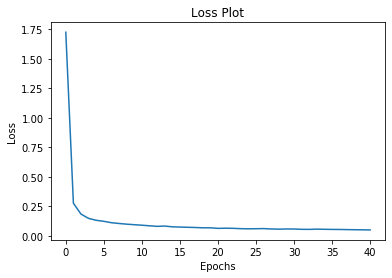

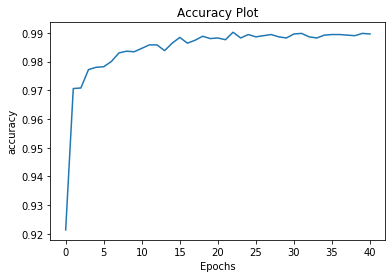

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.9888    0.9949    0.9919       980
           1     0.9886    0.9938    0.9912      1135
           2     0.9903    0.9913    0.9908      1032
           3     0.9795    0.9931    0.9862      1010
           4     0.9909    0.9939    0.9924       982
           5     0.9876    0.9832    0.9854       892
           6     0.9937    0.9854    0.9895       958
           7     0.9826    0.9874    0.9850      1028
           8     0.9906    0.9754    0.9829       974
           9     0.9870    0.9792    0.9831      1009

    accuracy                         0.9879     10000
   macro avg     0.9880    0.9877    0.9878     10000
weighted avg     0.9879    0.9879    0.9879     10000

Test accuracy 0.9879


In [0]:
for emb_dim,emb_proj_dim in emb_proj_list:
  modelpath=path+'/emb_'+str(emb_dim)+'_proj_'+str(emb_proj_dim)
  os.makedirs(modelpath,exist_ok=True)  
  #Hyperparameters tuning on learning rate
  for rate in rate_list:
    for batch_size in batch_size_list:
      print("------------------------------------")
      print("HyperModel Training")
      print("Emd_dim=",emb_dim)
      print("Emd_proj_dim=",emb_proj_dim)
      print("HyperParameters")
      print("Batch size ",batch_size)
      print("Adam Optimizer initial rate ",rate)
      #Datasets initialization
      MNIST=read_data_sets( x_train[:55000],y_train[:55000],x_train[55000:],y_train[55000:],x_test, y_test)
      exppath=modelpath+'/rate_'+str(rate)+'_batch_'+str(batch_size)+'/'  
      os.makedirs(exppath,exist_ok=True)    
      # Model initialization
      model=HyperModelA(emb_dim=emb_dim,emb_proj_dim=emb_proj_dim,filter_size=7)
      train_param=train_parameters(batch_size=batch_size,optimizer='adam',num_epochs=41,learning_rate=rate,rate_decay=0.999,savepath=exppath)
      print("------------------------------------")
      print("Training....")
      print("------------------------------------")
      train_model(model,MNIST,train_param)
      print("Test report saved in MNIST folder and subfolder named as per parameters....")
      test_report(model,MNIST,train_param)      

# Two Layer Conv Model

In [0]:

'''
  Parameters-
  input_shape=(height,width,channels)
'''
class ConvModel(tf.keras.Model):
  def __init__(self,filter_size=7,input_shape=(28,28,1),num_class=10):
    super(ConvModel, self).__init__()
    self.num_class=num_class
    self.filter_size=filter_size
    
    #First Conv Block 
    self.conv1_layer = Conv2D(16,  [self.filter_size,self.filter_size], padding='same', activation='relu', input_shape=(28, 28 ,1),name='main_conv1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    
    #Second Conv block
    self.conv2_layer = Conv2D(16,  [self.filter_size,self.filter_size], padding='same', activation='relu',name='main_conv2')
    self.max2_layer=MaxPool2D(pool_size=(2,2),name='main_max2')


    #final layer
    self.flatten_layer=Flatten()
    self.final_layer=Dense(units=num_class, activation='softmax',name='main_final_dense')

  def call(self, x):
    conv1_outputs=self.conv1_layer(x)
    block1_outputs=self.max1_layer(conv1_outputs)
    conv2_outputs=self.conv2_layer(block1_outputs)
    block2_outputs=self.max2_layer(conv2_outputs)
    prob=self.final_layer(self.flatten_layer(block2_outputs))
    return prob


In [0]:
# Hyper paramter tuning list
dataset='MNIST'
name='convmodel'
path=dataset+'/'+name
os.makedirs(path,exist_ok=True)

rate_list=[0.004]
batch_size_list=[1000]

------------------------------------
ConvModel Training
HyperParameters
Batch size  1000
Adam Optimizer initial rate  0.004
------------------------------------
Training....
------------------------------------

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Best Validation Accuracy 0.9888
Model: "conv_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_conv1 (Conv2D)          multiple                  800       
_____________________________________________

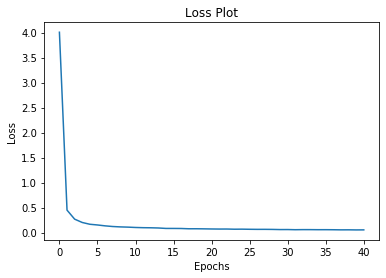

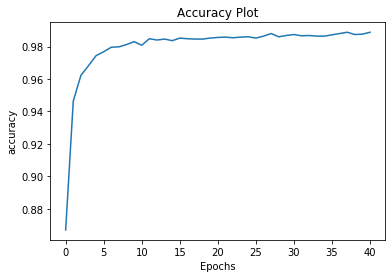

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.9848    0.9898    0.9873       980
           1     0.9921    0.9965    0.9943      1135
           2     0.9808    0.9893    0.9850      1032
           3     0.9910    0.9861    0.9886      1010
           4     0.9798    0.9888    0.9843       982
           5     0.9866    0.9877    0.9871       892
           6     0.9905    0.9802    0.9853       958
           7     0.9864    0.9893    0.9879      1028
           8     0.9836    0.9846    0.9841       974
           9     0.9909    0.9732    0.9820      1009

    accuracy                         0.9867     10000
   macro avg     0.9867    0.9866    0.9866     10000
weighted avg     0.9867    0.9867    0.9867     10000

Test accuracy 0.9867


In [0]:
  
  #Hyperparameters tuning on learning rate
for rate in rate_list:
  for batch_size in batch_size_list:
    print("------------------------------------")
    print("ConvModel Training")
    print("HyperParameters")
    print("Batch size ",batch_size)
    print("Adam Optimizer initial rate ",rate)
      #datasets initialization
    MNIST=read_data_sets( x_train[:55000],y_train[:55000],x_train[55000:],y_train[55000:],x_test, y_test)
    exppath=path+'/rate_'+str(rate)+'_batch_'+str(batch_size)+'/'  
    os.makedirs(exppath,exist_ok=True)    
    # Model initialization
    model=ConvModel(filter_size=7)
    train_param=train_parameters(batch_size=batch_size,optimizer='adam',num_epochs=41,learning_rate=rate,rate_decay=0.999,savepath=exppath)
    print("------------------------------------")
    print("Training....")
    print("------------------------------------")
    train_model(model,MNIST,train_param)
    print("Test report saved in MNIST folder and subfolder named as per parameters....")
    test_report(model,MNIST,train_param)      

# Weight Visualization

In [0]:
def show_filter(w_orig):
  w = w_orig.T
  the_shape = w_orig.shape
  print(the_shape)
  f_size = the_shape[0]
  in_dim =the_shape[2]
  out_dim = the_shape[3]
  print("mean =", np.mean(w))
  print("stddev =", np.std(w))
  print("max =", np.max(w))
  print("min =", np.min(w))
  print("median =", np.median(w))
  canvas = np.zeros(((f_size+1)*out_dim, (f_size+1)*in_dim))
  for i in range(out_dim):
    for j in range(in_dim):
      canvas[i*(f_size+1):i*(f_size+1)+f_size,j*(f_size+1):j*(f_size+1)+f_size] = w[i, j]
  plt.figure(figsize=(16, 16))
  canvas_fixed = np.zeros((canvas.shape[0]+1,canvas.shape[1]+1))
  canvas_fixed[1:,1:] = canvas

  plt.imshow(canvas_fixed.T, cmap='Greys', interpolation='nearest')
  plt.savefig("Convmodel.png")
  plt.axis('off')

(7, 7, 16, 16)
mean = -0.01851613713713693
stddev = 0.020207687100520257
max = 0.13328945485890845
min = -0.13679819561325268
median = -0.02107946611336287


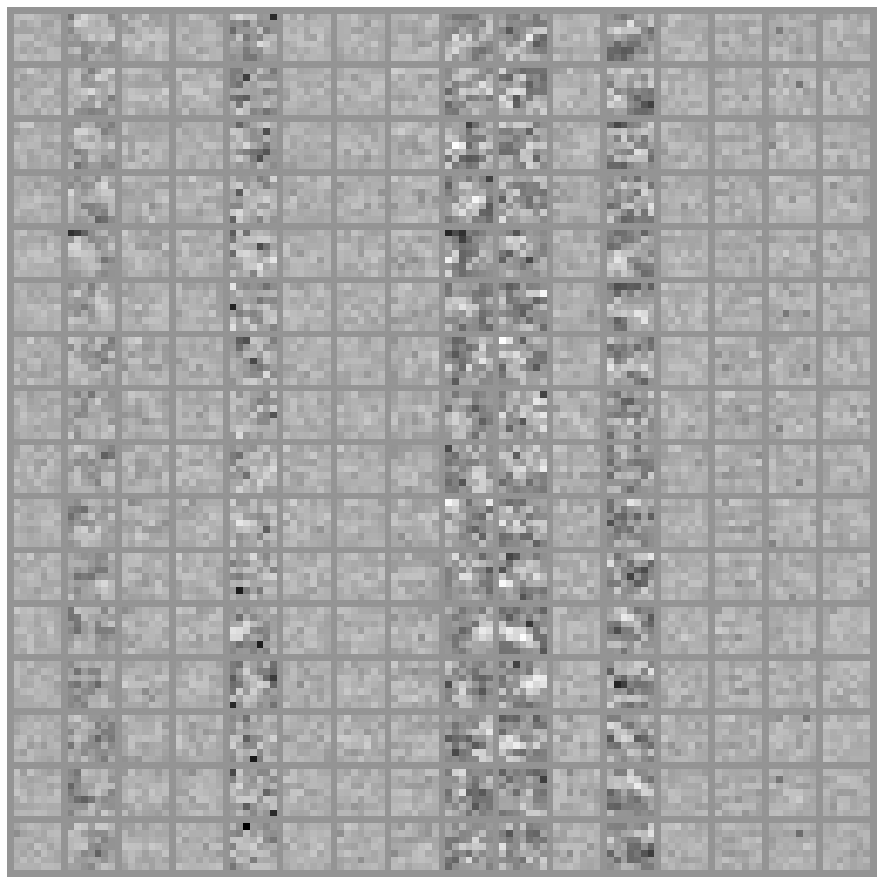

In [0]:
show_filter(model.hnet(model.conv2_hlayer.emb).numpy()[0,:,:,:,:])

(7, 7, 16, 16)
mean = -0.02128332942245834
stddev = 0.04055399610664086
max = 0.22136082029151077
min = -0.3241749198416683
median = -0.021492244394292287


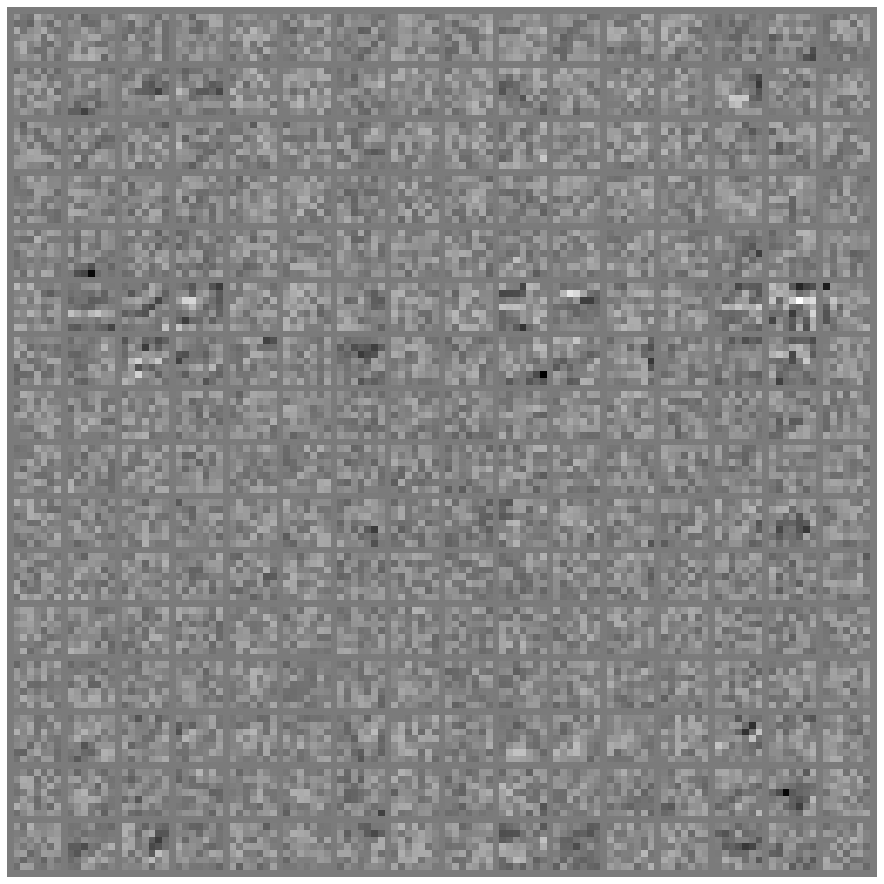

In [0]:
show_filter(model.conv2_layer.get_weights()[0])